# dataset + library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

census = pd.read_csv('/content/drive/MyDrive/[공모전]캐글 소기업 밀도 예측/microbusiness dataset/공식 데이터셋/census_starter.csv')
submission = pd.read_csv('/content/drive/MyDrive/[공모전]캐글 소기업 밀도 예측/microbusiness dataset/공식 데이터셋/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/[공모전]캐글 소기업 밀도 예측/microbusiness dataset/공식 데이터셋/train.csv')
test = pd.read_csv('/content/drive/MyDrive/[공모전]캐글 소기업 밀도 예측/microbusiness dataset/공식 데이터셋/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gc # memory management
!pip install xgboost==1.7.3
import xgboost as xgb
from tqdm.notebook import tqdm # progress display
# from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
# SMAPE function
def smape(y_true, y_pred):
    # array for SMAPE values
    smap = np.zeros(len(y_true))
    # numerator and denominator of SMAPE formula
    num = np.abs(y_true - y_pred)
    dem = (np.abs(y_true) + np.abs(y_pred)) / 2
    # indices excluding (y_true, y_pred)==(0,0)
    pos_ind = (y_true!=0)|(y_pred!=0)
    # values for calculating SMAPE
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    # SMAPE
    return 100 * np.mean(smap)
# VSMAPE function; element-wise SMAPE values
def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))    
    num = np.abs(y_true - y_pred)
    dem = (np.abs(y_true) + np.abs(y_pred)) / 2
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    # SMAPE values
    return 100 * smap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# preprocessing

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25080 entries, 0 to 25079
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              25080 non-null  object
 1   cfips               25080 non-null  int64 
 2   first_day_of_month  25080 non-null  object
dtypes: int64(1), object(2)
memory usage: 587.9+ KB


In [ ]:
# 데이터셋 표시
train['istest'] = 0
test['istest'] = 1
# 합치기
raw = pd.concat([train, test]).sort_values(['cfips','row_id']).reset_index(drop=True)
# 날짜형
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
# test에 없던 county, state 열 채우기
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
# year, month 열 생성
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
# dcount 열 : 각 카운티 내에서 row_id의 순서로 증가하는 정수 0~46; 시간 범주 train 39개 + test 8개
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
# county_i 열 : '카운티+주' 범주를 정수 0~3134로 인코딩
raw['county_i'] = (raw['county']+raw['state']).factorize()[0]
# state_i 열 : '주' 범주를 정수 0~50으로 인코딩
raw['state_i'] = raw['state'].factorize()[0]
raw.tail(20)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50


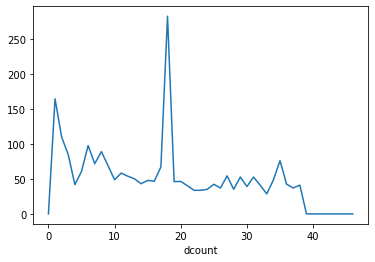

In [ ]:
lag = 1
# mbd_lag_1 열 : microbusiness_density 열의 값을 1칸 이동하여 저장
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
# dif 열 : mbd_lag_1에 대한 microbusiness_density의 비를 계산하고 하한을 0으로 설정한 후 -1
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
# 단, mbd_lag_1이 0이면 dif도 0으로 하되, 동시에 microbusiness_density가 0보다 크면 dif는 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
# 절댓값으로 저장
raw['dif'] = raw['dif'].abs()
# dcount가 같은 dif의 합 시각화; 카운티 구분을 배제
raw.groupby('dcount')['dif'].sum().plot();

> dcount가 18(18번 시간 범주)일 때 dif 이상치

In [ ]:
raw.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000


In [ ]:
outliers = []
cnt = 0

for o in tqdm(raw.cfips.unique()): # 카운티 iterator
    # 불 인덱싱을 통해 해당 카운티의 소기업 밀도 데이터 추출
    indices = (raw['cfips']==o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()

    for i in range(37, 2, -1):
        # 특정 카운티의 소기업 밀도 중 처음 i개(0~i-1)의 평균의 20%
        thr = 0.20 * np.mean(var[:i])
        # i번와 i-1번 소기업 밀도의 차이
        difa = abs(var[i]-var[i-1])
        # 연속적인 두 소기업 밀도의 차가 임계값을 넘으면 var[:i]에 (var[i] / var[i-1])를 곱하여 저장하고, 해당 카운티를 이상치로 추가
        if (difa>=thr):
            var[:i] *= (var[i] / var[i-1])
            outliers.append(o)
            cnt+=1
    # 1번 소기업 밀도의 99%를 0번 소기업 밀도로 저장        
    var[0] = var[1] * 0.99
    # 원본 데이터프레임의 소기업 밀도 데이터 갱신
    raw.loc[indices, 'microbusiness_density'] = var

# 이상치 카운티를 중복 없이 저장    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

<ipython-input-85-b87cf7be93ca>:17: RuntimeWarning: invalid value encountered in double_scalars
  var[:i] *= (var[i] / var[i-1])
<ipython-input-85-b87cf7be93ca>:17: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= (var[i] / var[i-1])
<ipython-input-85-b87cf7be93ca>:17: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i] / var[i-1])
<ipython-input-85-b87cf7be93ca>:14: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i]-var[i-1])


(481, 732)

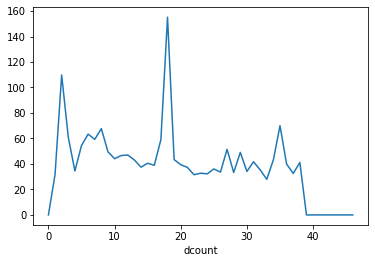

In [ ]:
# 이전 코드와 동일하지만, 이상치를 처리한 후 실행; y축 스케일 다름
lag = 1
# mbd_lag_1 열 : microbusiness_density 열의 값을 1칸 이동하여 저장
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
# dif 열 : mbd_lag_1에 대한 microbusiness_density의 비를 계산하고 하한을 0으로 설정한 후 -1
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
# 단, mbd_lag_1이 0이면 dif도 0으로 하되, 동시에 microbusiness_density가 0보다 크면 dif는 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
# 절댓값으로 저장
raw['dif'] = raw['dif'].abs()
# dcount가 같은 dif의 합 시각화; 카운티 구분을 배제
raw.groupby('dcount')['dif'].sum().plot();

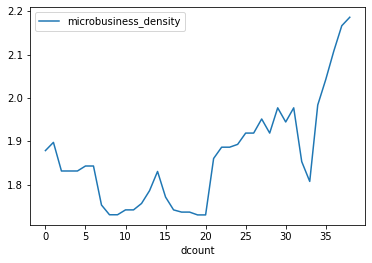

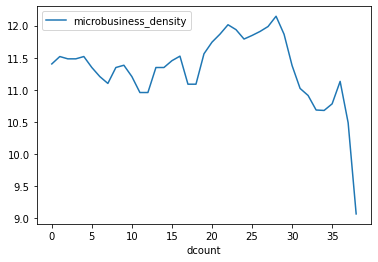

In [ ]:
# 1013번 카운티에서만 시간에 따른 소기업 밀도 확인
raw.loc[raw.cfips==1013].plot(x='dcount', y='microbusiness_density')
# 21215번 카운티에서만 시간에 따른 소기업 밀도 확인
raw.loc[raw.cfips==21215].plot(x='dcount', y='microbusiness_density');

In [ ]:
raw.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.856021,1249.0,0,2019,8,0,0,0,2.856021,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,2.856021,0.010101
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000


In [ ]:
# target 열 : (익월의 소기업 밀도 / 금월의 소기업 밀도) - 1 
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1 # 변화율
# 28055, 48269번 카운티의 target 열을 0으로 저장
raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0
raw.iloc[-20:,:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif,target
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50,1.670559,0.053763,0.020408
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50,1.760374,0.020408,-0.025949
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50,1.796300,0.025949,0.000000
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50,1.749688,0.000000,0.010204
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50,1.749688,0.010204,0.000000
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50,1.767542,0.000000,0.020202
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50,1.767542,0.020202,0.000000
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50,1.803249,0.000000,0.000000
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50,1.803249,0.000000,-0.009901
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50,1.803249,0.009901,0.000000


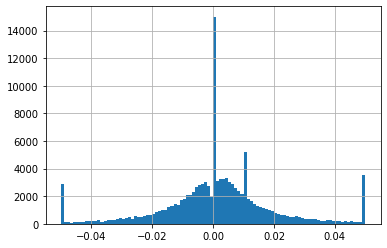

In [ ]:
# target 값을 -0.05와 0.05 사이로 제한하고 히스토그램으로 분포 확인
raw['target'].clip(-0.05, 0.05).hist(bins=100);

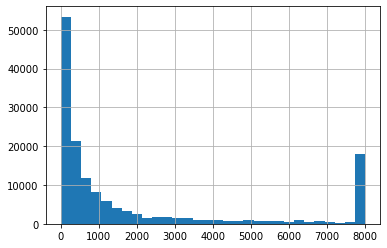

In [ ]:
# 카운티별로 가장 최근 관측 시점의 소기업 빈도를 추출하여 저장
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')
# 관측 시점 28번에서의 해당 카운티의 소기업 밀도를 저장
dt = raw.loc[raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')
raw['lasttarget'] = raw['cfips'].map(dt)
# 가장 최근 소기업 빈도를 0과 8000사이로 제한하고 히스토그램으로 분포 확인
raw['lastactive'].clip(0, 8000).hist(bins=30);

# feature engineering

In [ ]:
# 시간 차에 기반한 특징 생성 함수
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags=6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')    
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        # raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')    
    return raw, feats

raw, feats = build_features(raw, 'target', 'active', lags=4)
features = ['state_i']
features += feats
print(features)
raw.loc[raw.dcount==38, features].head(10) # 가장 최근 시점

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884


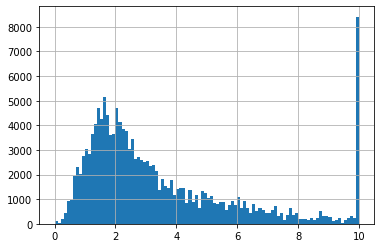

In [ ]:
# lasttarget 열을 0과 10 사이로 제한하고 히스토그램으로 분포 확인
raw['lasttarget'].clip(0,10).hist(bins=100);

# 모델 생성(리뷰 안함)

[beginner version]https://www.kaggle.com/code/joshuascj/better-xgb-baseline-understanding-for-beginners

In [ ]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]
ACT_THR = 1.8
ABS_THR = 1.00
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
VAL = []
BEST_ROUNDS = []
for TS in range(29, 38):
    print(TS)
    
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        # objective='reg:squarederror',
        tree_method="hist",
        n_estimators=4999,
        learning_rate=0.0075,
        max_leaves = 17,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        eval_metric='mae',
        early_stopping_rounds=70,
    )
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
    valid_indices = (raw.istest==0) & (raw.dcount == TS)
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,
    )
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration)
    ypred = model.predict(raw.loc[valid_indices, features])
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
    df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
    df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('XGB SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()


ind = (raw.dcount>=30)&(raw.dcount<=38)
print( 'XGB SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last'] ) )

In [ ]:
raw['error'] = vsmape(raw['microbusiness_density'], raw['ypred'])
raw['error_last'] = vsmape(raw['microbusiness_density'], raw['ypred_last'])
raw.loc[(raw.dcount==30), ['microbusiness_density', 'ypred', 'error', 'error_last'] ]

In [ ]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt = dt.groupby('cfips')['miss'].mean()
dt = dt.loc[dt>=0.50]
dt.shape

In [ ]:
len(dt.index)
# 'dt'라는 데이터프레임의 인덱스의 길이를 구하는 것입니다. 'len' 함수는 객체의 요소 개수를 반환합니다. 여기서는 'dt' 데이터프레임의 인덱스를 세어 그 개수를 반환하여 데이터프레임의 행 수를 구합니다. 이 인덱스는 데이터프레임의 각 행의 고유 식별자를 나타내며, 인덱스 길이는 데이터프레임의 행 수와 같습니다.

In [ ]:
','.join([str(i) for i in dt.index])
# 'dt'라는 데이터프레임의 인덱스 요소를 하나의 문자열로 합치는 것입니다.먼저 인덱스를 반복하면서 각 요소를 문자열로 변환하여 리스트를 생성합니다. 그리고 join() 함수를 사용하여 리스트의 모든 요소를 콤마로 구분되는 하나의 문자열로 합칩니다.

In [ ]:
for d in dt.index[:10]:
    raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))
    

# 'dt' 데이터프레임 인덱스의 첫 10개 요소에 대해 'raw' 데이터프레임의 'microbusiness_density'와 'ypred' 두 열의 데이터를 그리는 것입니다. for 루프를 사용하여 'dt' 인덱스의 첫 10개 요소를 반복하고, 각 요소에 대해 'cfips' 열이 현재 요소와 같은 행을 선택하는 'loc'를 사용합니다.
# 그리고 plot 메서드를 사용하여 'microbusiness_density'와 'ypred' 열의 데이터를 이러한 행에 대해 그립니다. 그래프의 x축은 'dcount' 열이며 그래프 제목은 현재 'dt' 데이터프레임 인덱스의 요소로 설정됩니다.
# 이렇게 하면 'dt' 데이터프레임 인덱스의 각 요소에 대한 각각의 'cfips'와 'dcount'열을 가지는 여러 그래프를 생성합니다

In [ ]:
raw.iloc[-40:, :16]
# 데이터프레임의 .iloc 속성을 사용하여 데이터프레임을 슬라이스하는 것 같습니다. 특히나 마지막 40 행과 첫 16 열을 요청하고 있습니다.

In [ ]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS
# numpy 라이브러리를 사용하여 'BEST_ROUNDS' 변수의 평균, 중앙값, 원래 배열을 계산하려고 하는 것 같습니다.

In [ ]:
best_rounds = int(np.median( BEST_ROUNDS )+1)
# numpy 라이브러리의 median 함수를 사용하여 'BEST_ROUNDS' 변수의 중앙값을 계산하고, 그 값에 1을 더한 다음 정수로 캐스팅하려는 것 같습니다.
best_rounds

In [ ]:
TS = 38
print(TS)

model0 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    # objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)
model1 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    # objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
valid_indices = (raw.dcount == TS)
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)
model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)

ypred = (model0.predict(raw.loc[valid_indices, features]) + model1.predict(raw.loc[valid_indices, features]))/2
raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

# Validate
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

In [ ]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [ ]:
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k']].tail(20)

In [ ]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
# 데이터프레임 (이름이 'raw')의 .loc 속성을 사용하여 'cfips' 열이 28055와 같은 행을 선택하고 'microbusiness_density' 열의 값을 0으로 업데이트하려는 것 같습니다.
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
# 데이터프레임 'raw'의 .loc 속성을 사용하여 'dcount' 열이 39인 행을 선택한 다음, 그 행에서 'cfips'와 'ypred' 열을 선택합니다. 그런 다음 'cfips' 열을 인덱스로 설정하고 .to_dict() 메소드를 사용하여 결과 데이터프레임을 딕셔너리로 변환합니다. 딕셔너리의 키는 'ypred'이고 값은 'ypred' 열에 해당하는 값입니다.
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
# 데이터프레임 'raw'에서 'istest' 열이 1인 행만을 포함하며 'row_id', 'cfips', 'microbusiness_density' 열만을 포함하는 새로운 데이터프레임 'test'를 만드려는 것 같습니다.
test['microbusiness_density'] = test['cfips'].map(dt)
# 이 코드는 'test' 데이터프레임의 'cfips' 열에 .map() 함수를 사용하여 'dt' 사전을 적용하는 것으로 'microbusiness_density' 열의 값을 'dt' 사전의 'cfips' 열에 대응하는 값으로 대체합니다.

test[['row_id','microbusiness_density']].to_csv('submission.csv', index=False)
# 'test' 데이터프레임에 .to_csv() 메소드를 사용하여 파일 이름을 'submission.csv'로 지정하고 인덱스를 False로 설정합니다. 그리고 'row_id'와 'microbusiness_density' 열만 선택하여 csv 파일로 저장합니다.
 
test.head(40)